In [301]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [302]:
df = pd.read_csv('RegressorDataset.csv', index_col=[0], parse_dates=[0])
df

,LineLength,LocationId,MealType,MenuItem
Datetime,,,,
2018-08-28 12:21:00,150,Ford,Breakfast,Scrambled Eggs
2018-08-28 12:21:00,150,Ford,Breakfast,Scrambled Eggs w/Ham & Cheese
2018-08-28 12:21:00,150,Ford,Breakfast,Sweet Smoked Rope Sausage
2018-08-28 12:21:00,150,Ford,Breakfast,Pancakes
2018-08-28 12:21:00,150,Ford,Breakfast,Pancake Syrup Sugar Free
...,...,...,...,...
2017-11-02 17:58:00,200,Hillenbrand,Dinner,Tropical Fruit Salad
2017-11-02 17:58:00,200,Hillenbrand,Dinner,Shortbread Cookie
2017-11-02 17:58:00,200,Hillenbrand,Dinner,Chocolate Chip Cookie


df = pd.read_csv('WaitTimesRegression.csv', index_col=[0], parse_dates=[0])
df

In [303]:
#replace categorical columns with text with categorical column with numerical values

df.LocationId = pd.Categorical(df.LocationId)
df['LocationIdCode'] = df.LocationId.cat.codes
del df['LocationId']

df.MealType = pd.Categorical(df.MealType)
df['MealTypeCode'] = df.MealType.cat.codes
del df['MealType']

df.MenuItem = pd.Categorical(df.MenuItem)
df['MenuItemCode'] = df.MenuItem.cat.codes
del df['MenuItem']

df.loc[df['LocationId'] == "Earhart"]

color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='.', figsize=(15,5), color=color_pal[0], title='Dining Court Wait-Times')

In [304]:
#add datasets for distinct dining courts
#earhart: 0 ford: 1 hillenbrand: 2 Wiley: 3 Windsor: 4

df_earhart = df.loc[df['LocationIdCode'] == 0]
df_ford = df.loc[df['LocationIdCode'] == 1]
df_hillenbrand = df.loc[df['LocationIdCode'] == 2]
df_wiley = df.loc[df['LocationIdCode'] == 3]
df_windsor = df.loc[df['LocationIdCode'] == 4]

In [305]:
#splitting master
split_date = '01-Aug-2020'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

In [306]:
#splitting by dining courts
split_date = '01-Aug-2020'

df_earhart_train = df_earhart.loc[df_earhart.index <= split_date].copy() #27939 rows
df_earhart_test = df_earhart.loc[df_earhart.index > split_date].copy() #19567 rows

df_ford_train = df_ford.loc[df_ford.index <= split_date].copy() #51960 rows
df_ford_test = df_ford.loc[df_ford.index > split_date].copy() #10347 rows

df_hillenbrand_train = df_hillenbrand.loc[df_hillenbrand.index <= split_date].copy() #9363 rows
df_hillenbrand_test = df_hillenbrand.loc[df_hillenbrand.index > split_date].copy() #3620 rows

df_wiley_train = df_wiley.loc[df_wiley.index <= split_date].copy() #53468 rows
df_wiley_test = df_wiley.loc[df_wiley.index > split_date].copy() #12383 rows

df_windsor_train = df_windsor.loc[df_windsor.index <= split_date].copy() #35365 rows
df_windsor_test = df_windsor.loc[df_windsor.index > split_date].copy() #6458 rows

_ = df_test \
    .rename(columns={'LineLength': 'TEST SET'}) \
    .join(df_train.rename(columns={'LineLength': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Dining Court Wait-Times', style='.')

In [307]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    print(df)
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['hour','dayofweek','quarter','month','year',
        'dayofyear','dayofmonth','weekofyear', 'LocationIdCode', 'MealTypeCode', 'MenuItemCode']]
    
    print(X)
    if label:
        y = df[label]
        return X, y
    return X

In [308]:
#train and test for master
X_train, y_train = create_features(df_train, label='LineLength')
X_test, y_test = create_features(df_test, label='LineLength')

                     LineLength  LocationIdCode  MealTypeCode  MenuItemCode
Datetime                                                                   
2018-08-28 12:21:00         150               1             0          2453
2018-08-28 12:21:00         150               1             0          2459
2018-08-28 12:21:00         150               1             0          2779
2018-08-28 12:21:00         150               1             0          1981
2018-08-28 12:21:00         150               1             0          1977
...                         ...             ...           ...           ...
2017-11-02 17:58:00         200               2             1          2930
2017-11-02 17:58:00         200               2             1          2487
2017-11-02 17:58:00         200               2             1           711
2017-11-02 17:58:00         200               2             1          1567
2017-11-02 17:58:00         200               2             1          2246

[178095 row

<ipython-input-307-0d987608ff4c>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-307-0d987608ff4c>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [309]:
#train and test for distinct dining courts
X_train_earhart, y_train_earhart = create_features(df_earhart_train, label='LineLength')
X_test_earhart, y_test_earhart = create_features(df_earhart_test, label='LineLength')

X_train_ford, y_train_ford = create_features(df_ford_train, label='LineLength')
X_test_ford, y_test_ford = create_features(df_ford_test, label='LineLength')

X_train_hillenbrand, y_train_hillenbrand = create_features(df_hillenbrand_train, label='LineLength')
X_test_hillenbrand, y_test_hillenbrand = create_features(df_hillenbrand_test, label='LineLength')

X_train_wiley, y_train_wiley = create_features(df_wiley_train, label='LineLength')
X_test_wiley, y_test_wiley = create_features(df_wiley_test, label='LineLength')

X_train_windsor, y_train_windsor = create_features(df_windsor_train, label='LineLength')
X_test_windsor, y_test_windsor = create_features(df_windsor_test, label='LineLength')

<ipython-input-307-0d987608ff4c>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-307-0d987608ff4c>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


                     LineLength  LocationIdCode  MealTypeCode  MenuItemCode
Datetime                                                                   
2019-10-17 13:36:00         200               0             0          2453
2019-10-17 13:36:00         200               0             0          2072
2019-10-17 13:36:00         200               0             0           659
2019-10-17 13:36:00         200               0             0          1421
2019-10-17 13:36:00         200               0             0          2908
...                         ...             ...           ...           ...
2020-01-26 12:48:00          75               0             3           419
2020-01-26 12:48:00          75               0             3          2105
2020-01-26 12:48:00          75               0             3          1207
2020-01-26 12:48:00          75               0             3          1670
2020-01-26 12:48:00          75               0             3          2314

[27939 rows

[9363 rows x 11 columns]
                     LineLength  LocationIdCode  MealTypeCode  MenuItemCode
Datetime                                                                   
2020-08-25 10:48:00          25               2             3           114
2020-08-25 10:48:00          25               2             3          1825
2020-08-25 10:48:00          25               2             3          1381
2020-08-25 10:48:00          25               2             3          1810
2020-08-25 10:48:00          25               2             3          2602
...                         ...             ...           ...           ...
2020-08-20 11:49:00         200               2             1          1537
2020-08-20 11:49:00         200               2             1           464
2020-08-20 11:49:00         200               2             1           578
2020-08-20 11:49:00         200               2             1          1288
2020-08-20 11:49:00         200               2             1  

<ipython-input-307-0d987608ff4c>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-307-0d987608ff4c>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-307-0d987608ff4c>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-307-0d987608ff4c>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-307-0d987608ff4c>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week inste

                     hour  dayofweek  quarter  month  year  dayofyear  \
Datetime                                                                
2020-08-25 10:48:00    10          1        3      8  2020        238   
2020-08-25 10:48:00    10          1        3      8  2020        238   
2020-08-25 10:48:00    10          1        3      8  2020        238   
2020-08-25 10:48:00    10          1        3      8  2020        238   
2020-08-25 10:48:00    10          1        3      8  2020        238   
...                   ...        ...      ...    ...   ...        ...   
2020-08-20 11:49:00    11          3        3      8  2020        233   
2020-08-20 11:49:00    11          3        3      8  2020        233   
2020-08-20 11:49:00    11          3        3      8  2020        233   
2020-08-20 11:49:00    11          3        3      8  2020        233   
2020-08-20 11:49:00    11          3        3      8  2020        233   

                     dayofmonth  weekofyear  Locat

<ipython-input-307-0d987608ff4c>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [310]:
#model for master
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [311]:
y_pred_1_ini = reg.predict(X_test)

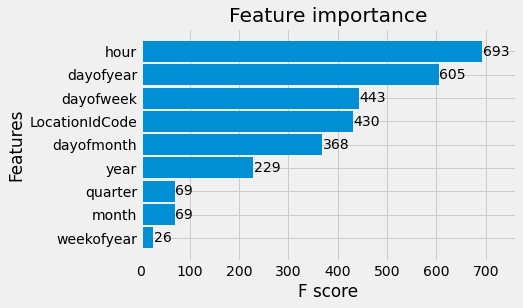

In [312]:
_ = plot_importance(reg, height=0.9)

In [313]:
df_test['LineLengthPrediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

In [314]:
#calibrate predition values
df_all.LineLengthPrediction = df_all.LineLengthPrediction * 1.25

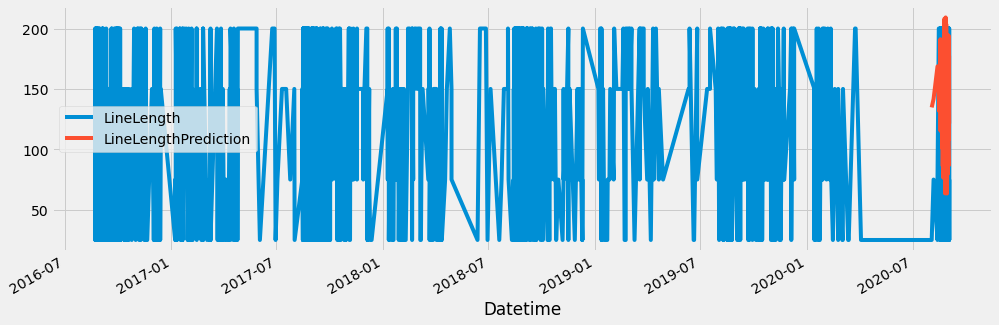

In [315]:
_ = df_all[['LineLength','LineLengthPrediction']].plot(figsize=(15, 5))

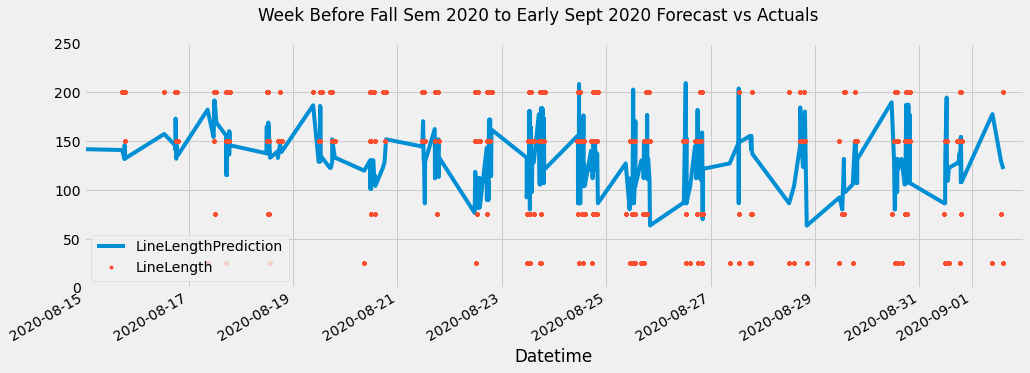

In [316]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['LineLengthPrediction','LineLength']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 250)
ax.set_xbound(lower='08-15-2020', upper='09-02-2020')
plot = plt.suptitle('Week Before Fall Sem 2020 to Early Sept 2020 Forecast vs Actuals')

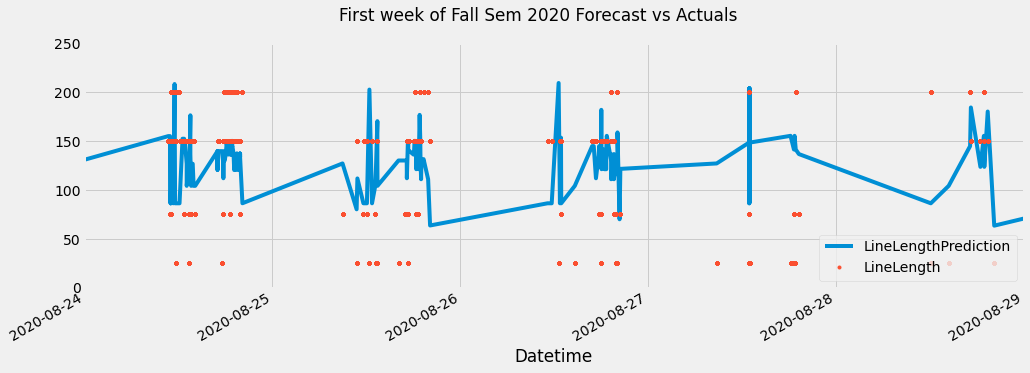

In [317]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['LineLengthPrediction','LineLength']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 250)
ax.set_xbound(lower='08-24-2020', upper='08-29-2020')
plot = plt.suptitle('First week of Fall Sem 2020 Forecast vs Actuals')

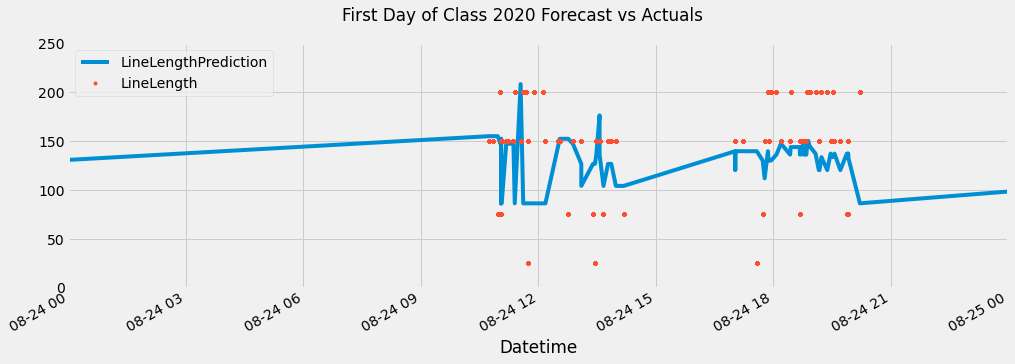

In [318]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['LineLengthPrediction','LineLength']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 250)
ax.set_xbound(lower='08-24-2020', upper='08-25-2020')
plot = plt.suptitle('First Day of Class 2020 Forecast vs Actuals')

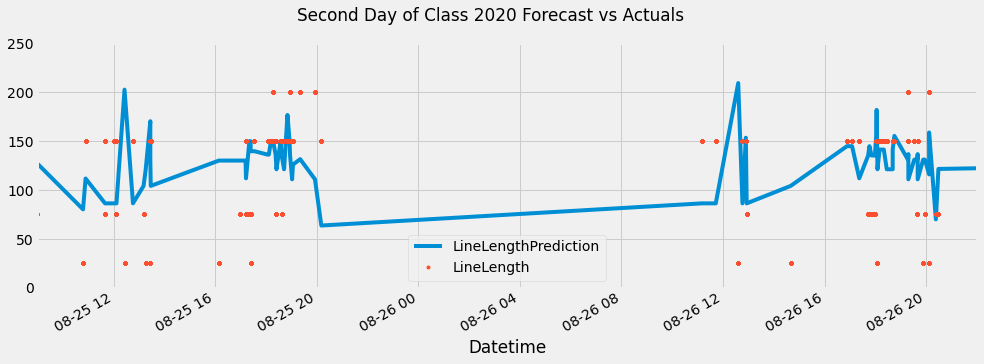

In [319]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['LineLengthPrediction','LineLength']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 250)
ax.set_xbound(lower='08-25-2020 09', upper='08-26-2020 22')
plot = plt.suptitle('Second Day of Class 2020 Forecast vs Actuals')

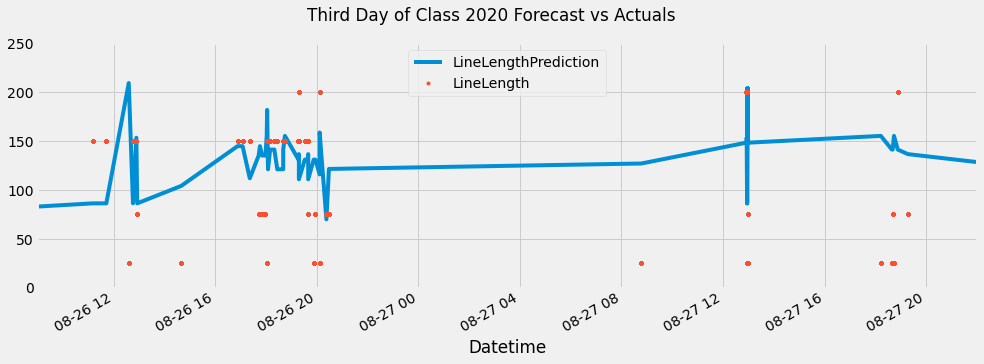

In [320]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['LineLengthPrediction','LineLength']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 250)
ax.set_xbound(lower='08-26-2020 09', upper='08-27-2020 22')
plot = plt.suptitle('Third Day of Class 2020 Forecast vs Actuals')

In [321]:
#create a function that takes in the date, dining court, menu item? return plot. build ui next sprint.

In [322]:
#model for earhart
reg_earhart = xgb.XGBRegressor(n_estimators=1000)
reg_earhart.fit(X_train_earhart, y_train_earhart,
        eval_set=[(X_train_earhart, y_train_earhart), (X_test_earhart, y_test_earhart)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

#model for hillenbrand
reg_hillenbrand = xgb.XGBRegressor(n_estimators=1000)
reg_hillenbrand.fit(X_train_hillenbrand, y_train_hillenbrand,
        eval_set=[(X_train_hillenbrand, y_train_hillenbrand), (X_test_hillenbrand, y_test_hillenbrand)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

#model for ford
reg_hillenbrand = xgb.XGBRegressor(n_estimators=1000)
reg_hillenbrand.fit(X_train_hillenbrand, y_train_hillenbrand,
        eval_set=[(X_train_hillenbrand, y_train_hillenbrand), (X_test_hillenbrand, y_test_hillenbrand)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

#model for wiley
reg_wiley = xgb.XGBRegressor(n_estimators=1000)
reg_wiley.fit(X_train_wiley, y_train_wiley,
        eval_set=[(X_train_wiley, y_train_wiley), (X_test_wiley, y_test_wiley)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

#model for windsor
reg_windsor = xgb.XGBRegressor(n_estimators=1000)
reg_windsor.fit(X_train_windsor, y_train_windsor,
        eval_set=[(X_train_windsor, y_train_windsor), (X_test_windsor, y_test_windsor)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train


y_pred_1_ini_earhart = reg_earhart.predict(X_test_earhart)
y_pred_1_ini_ford = reg_ford.predict(X_test_ford)
y_pred_1_ini_hillenbrand = reg_hillenbrand.predict(X_test_hillenbrand)
y_pred_1_ini_wiley = reg_wiley.predict(X_test_wiley)
y_pred_1_ini_windsor = reg_windsor.predict(X_test_windsor)


df_earhart_test['LineLengthPrediction'] = reg_earhart.predict(X_test_earhart)
df_all_earhart = pd.concat([df_earhart_test, df_earhart_train], sort=False)
df_all_earhart.LineLengthPrediction = df_all_earhart.LineLengthPrediction * 1.25

df_ford_test['LineLengthPrediction'] = reg_ford.predict(X_test_ford)
df_all_ford = pd.concat([df_ford_test, df_ford_train], sort=False)
df_all_ford.LineLengthPrediction = df_all_ford.LineLengthPrediction * 1.25

df_hillenbrand_test['LineLengthPrediction'] = reg_hillenbrand.predict(X_test_hillenbrand)
df_all_hillenbrand = pd.concat([df_hillenbrand_test, df_hillenbrand_train], sort=False)
df_all_hillenbrand.LineLengthPrediction = df_all_hillenbrand.LineLengthPrediction * 1.25

df_wiley_test['LineLengthPrediction'] = reg_wiley.predict(X_test_wiley)
df_all_wiley = pd.concat([df_wiley_test, df_wiley_train], sort=False)
df_all_wiley.LineLengthPrediction = df_all_wiley.LineLengthPrediction * 1.25

df_windsor_test['LineLengthPrediction'] = reg_windsor.predict(X_test_windsor)
df_all_windsor = pd.concat([df_windsor_test, df_windsor_train], sort=False)
df_all_windsor.LineLengthPrediction = df_all_windsor.LineLengthPrediction * 1.25

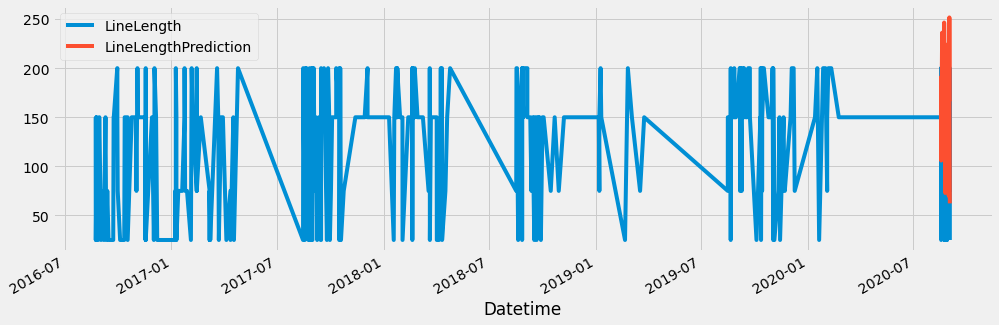

In [323]:
#visualizing preditions/actual for a dining court
_ = df_all_windsor[['LineLength','LineLengthPrediction']].plot(figsize=(15, 5))

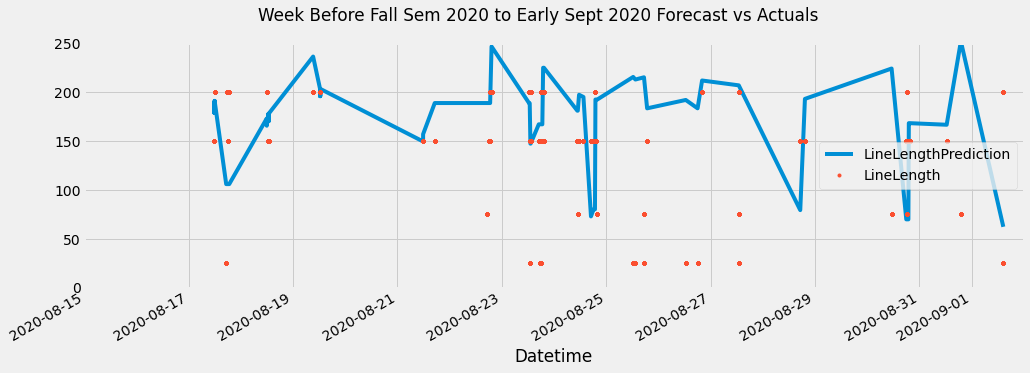

In [324]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all_windsor[['LineLengthPrediction','LineLength']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 250)
ax.set_xbound(lower='08-15-2020', upper='09-02-2020')
plot = plt.suptitle('Week Before Fall Sem 2020 to Early Sept 2020 Forecast vs Actuals')

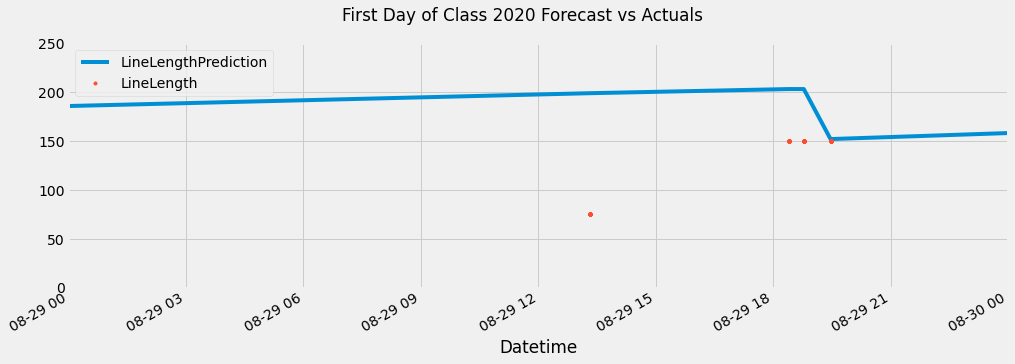

In [325]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all_wiley[['LineLengthPrediction','LineLength']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 250)
ax.set_xbound(lower='08-29-2020', upper='08-30-2020')
plot = plt.suptitle('First Day of Class 2020 Forecast vs Actuals')

In [393]:
import datetime

def plot_generator(diningCourt, date):

    inputDate = date

    month,day,year = inputDate.split('/')

    isValidDate = True
    try :
        datetime.datetime(int(year),int(month),int(day))
    except ValueError :
        isValidDate = False

    if(not isValidDate) :
        return "Input date is not valid."
        

    if (diningCourt == "earhart"):
        df_all_custom = df_all_earhart
    elif (diningCourt == "ford"):
        df_all_custom = df_all_ford
    elif (diningCourt == "hillenbrand"):
        df_all_custom = df_all_hillenbrand
    elif (diningCourt == "wiley"):
        df_all_custom = df_all_wiley
    elif (diningCourt == "windsor"):
        df_all_custom = df_all_windsor
    elif (diningCourt == "all"):
        df_all_custom = df_all
    else:
        print("please input proper dining court!")
        return
    dateTimeObj = datetime.datetime.strptime(date, '%m/%d/%y')
    dateFinal = dateTimeObj.date()
    nextDay = dateFinal + datetime.timedelta(days=1)
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    _ = df_all_custom[['LineLengthPrediction']].plot(ax=ax,
                                                  style=['-','.'])
    #_ = df_all_custom[['LineLengthPrediction','LineLength']].plot(ax=ax,style=['-','.'])
    ax.set_ylim(0, 250)
    ax.set_xbound(lower=dateFinal, upper=nextDay)
    ax.set_yticks([0,50,100,150,200])
    ax.set_yticklabels(['no line','in the lobby','filling the lobby','out the door', 'around the building'])
    plot = plt.suptitle(f'Forecasted queue length of {diningCourt.capitalize()} dining court for {dateFinal}')

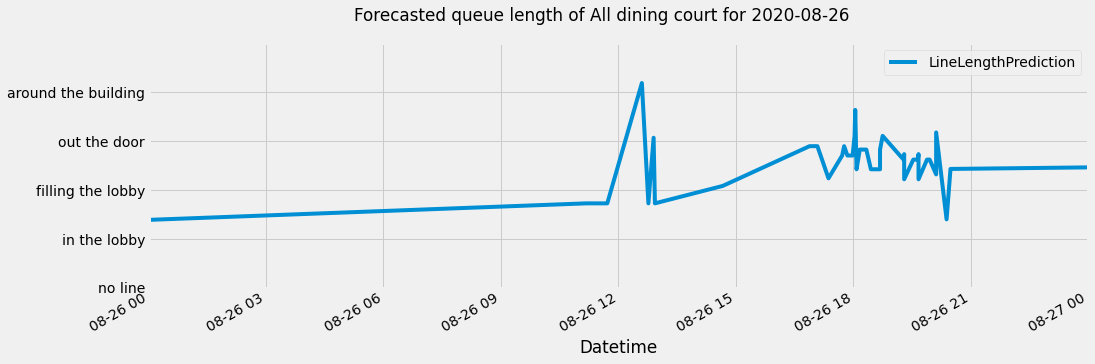

In [394]:
plot_generator("all", '08/26/20')